# Basic model tutorial

In this tutorial you will learn the basics of the model interface for a simple inline python model. The API for the model interface is provided here:

https://pressio.github.io/rom-tools-and-workflows/romtools/workflows/models.html


In [30]:
#First, let's import the relavant modules:
import romtools
import numpy as np
from matplotlib import pyplot as plt
from romtools.workflows import models

Text(0, 0.5, '$u$')

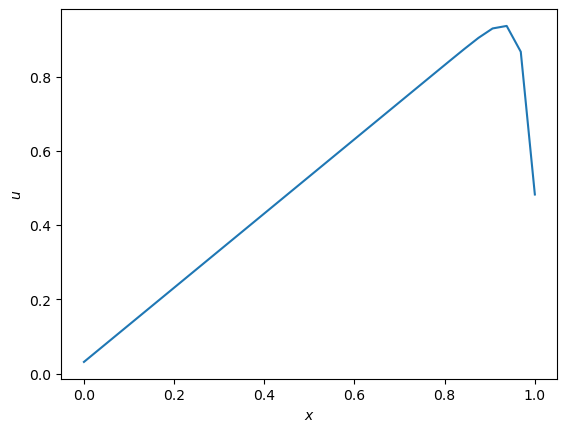

In [37]:
'''
Here, we will interface around a very basic model for solving the 1D poisson equation.
c u_x - nu * u_xx = 1
'''
# We will start with defining an advection diffusion problem. This class does NOT meet any interface related to romtools
class advectionDiffusionProblem:
    def __init__(self , nx):
        nx_ = nx
        self.x_ = np.linspace(0,1,nx)
        dx = 1. / (nx - 1)

        ## Assemble diffusion operator and assign boundary conditions
        self.Ad_ = np.zeros((nx,nx))
        self.Ad_[0,0] = -2./dx**2
        self.Ad_[0,1] = 1./dx**2
       
        self.Ad_[-1,-1] = -2./dx**2
        self.Ad_[-1,-2] = 1./dx**2
       
        for i in range(1,nx_ -1):
            self.Ad_[i,i] = -2./dx**2
            self.Ad_[i,i-1] = 1./dx**2
            self.Ad_[i,i+1] = 1./dx**2
        
        self.Ac_ = np.zeros((nx,nx))
        self.Ac_[0,0] = 1./dx
        for i in range(1,nx_ -1 ):
            self.Ac_[i,i] = 1/dx
            self.Ac_[i,i-1] = -1./dx
    
        self.f_ = np.ones(nx)

    def assemble_system(self,c,nu):
        self.A_ = c*self.Ac_ - nu*self.Ad_

    def solve(self,c,nu):
        self.assemble_system(c,nu)
        solution = np.linalg.solve(self.A_,self.f_)
        return solution

# As an example, we can insatiate this class and solve for a given parameter insance.
adr_problem = advectionDiffusionProblem(nx=33)
c,nu = 1.,1.e-2
u = adr_problem.solve(c,nu)
plt.plot(adr_problem.x_,u)
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')


In [35]:
## Now, let's create a romtools wrapper around this that meets the API of the ModelClass
class adrRomToolsModel:
    def __init__(self,problem: advectionDiffusionProblem):
        self.problem_ = advectionDiffusionProblem

    def populate_run_directory(self, run_directory: str, parameter_sample: dict):
        # In this example, we don't need any offline data to run our model, so this can be empty
        pass
        
    def run_model(self, run_directory: str, parameter_sample: dict):
        #parameter sample will come from a ParameterSpace object, and will be a dictionary of the form:
        #[{parameter_name},{value}]
        c = parameter_sample['c']
        nu = parameter_sample['nu']
        u = self.problem_.solve(c,nu)
        # return 0 for pass
        return 0


adr_for_romtools = adrRomToolsModel(adr_problem)

#That's it! This type of model can be used for running a sampling workflow. 